# Import Libraries

In [1]:
import numpy as np 
import pandas as pd 
import itertools
import matplotlib.pyplot as plt 
from PIL import Image
from tqdm import tqdm
from glob import glob
import seaborn as sns
import cv2 as cv
import os 

import torch
from sklearn.model_selection import train_test_split  
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Input, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

2025-08-15 01:05:37.132009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755219937.317784      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755219937.374179      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preprocessing

In [2]:
data_dir = '/kaggle/input/lgg-mri-segmentation/kaggle_3m'
images_path = []
masks_path = []

masks_path = glob(f'{data_dir}/*/*_mask*')

for mask in masks_path :
    images_path.append(mask.replace('_mask',''))

In [3]:
image_shape = (128,128)
channels = 3

def preprocessing_data():
    images = []
    masks = []
    for img_path, mask_path in zip(images_path, masks_path):
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        
        if img is None or mask is None :
            print(f'Failed to load image or mask : {img_path} : {mask_path}')

        img = cv.resize(img,image_shape)
        mask = cv.resize(mask,image_shape)
        img = img/255.0
        mask = mask/255.0

        images.append(img)
        masks.append(mask)

    if not images and not masks :
        raise ValueError('No Images Or Masks were Loaded..!')

    images_array = np.array(images,dtype = np.float32)
    masks_array = np.array(masks,dtype = np.float32)
    masks_array = np.expand_dims(masks_array,axis = -1)
    return images_array,masks_array

In [4]:
images,masks = preprocessing_data()
print('Images Shape :',images.shape)
print('Masks Shape :',masks.shape)

Images Shape : (3929, 128, 128, 3)
Masks Shape : (3929, 128, 128, 1)


# Splitting the data

In [5]:
x_train,x_test,y_train,y_test = train_test_split(images,masks,test_size = 0.2,random_state = 42)
x_train.shape

(3143, 128, 128, 3)

In [6]:
y_test.shape

(786, 128, 128, 1)

# Model Architecture

In [7]:
from tensorflow.keras.models import Model
def build_unet_model(input_size = (128,128,3)):
    input_shape = Input(input_size)
    # Encoder
    e1 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(input_shape)
    e1 = BatchNormalization()(e1)
    e1 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(e1)
    e1 = BatchNormalization()(e1)
    p1 = MaxPooling2D((2,2))(e1)

    e2 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(p1)
    e2 = BatchNormalization()(e2)
    e2 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(e2)
    e2 = BatchNormalization()(e2)
    p2 = MaxPooling2D((2,2))(e2)

    e3 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(p2)
    e3 = BatchNormalization()(e3)
    e3 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(e3)
    e3 = BatchNormalization()(e3)
    p3 = MaxPooling2D((2,2))(e3)

    e4 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(p3)
    e4 = BatchNormalization()(e4)
    e4 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(e4)
    e4 = BatchNormalization()(e4)
    p4 = MaxPooling2D((2,2))(e4)

    # Bottleneck
    b1 = Conv2D(512 , (3,3) , activation = 'relu' , padding = 'same')(p4)
    b1 = BatchNormalization()(b1)
    b1 = Conv2D(512 , (3,3) , activation = 'relu' , padding = 'same')(b1)
    b1 = BatchNormalization()(b1)

    # Decoder
    d1 = Conv2DTranspose(256 , (2,2) , strides = (2,2), activation = 'relu' , padding = 'same')(b1)
    d1 = Concatenate()([d1 , e4])
    d1 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Conv2D(256 , (3,3) , activation = 'relu' , padding = 'same')(d1)
    d1 = BatchNormalization()(d1)

    d2 = Conv2DTranspose(128 , (2,2) , strides = (2,2) , activation = 'relu' , padding = 'same')(d1)
    d2 = Concatenate()([d2 , e3])
    d2 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Conv2D(128 , (3,3) , activation = 'relu' , padding = 'same')(d2)
    d2 = BatchNormalization()(d2)

    d3 = Conv2DTranspose(64 , (2,2) , strides = (2,2) , activation = 'relu' , padding = 'same')(d2)
    d3 = Concatenate()([d3 , e2])
    d3 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Conv2D(64 , (3,3) , activation = 'relu' , padding = 'same')(d3)
    d3 = BatchNormalization()(d3)
    
    d4 = Conv2DTranspose(32 , (2,2) , strides = (2,2) , activation = 'relu' , padding = 'same')(d3)
    d4 = Concatenate()([d4 , e1])
    d4 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(d4)
    d4 = BatchNormalization()(d4)
    d4 = Conv2D(32 , (3,3) , activation = 'relu' , padding = 'same')(d4)
    d4 = BatchNormalization()(d4)
    # Output layer
    outputs = Conv2D(1, (1,1), activation='sigmoid')(d4)
    
    return Model(input_shape,outputs)

In [8]:
model = build_unet_model()
model.summary()

I0000 00:00:1755220028.488322      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755220028.489002      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

## Applying Dice Coefficient

In [9]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) /
                (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))

## Combined with Binary Crossentropy

In [10]:
from tensorflow.keras.losses import BinaryCrossentropy

bce = BinaryCrossentropy()

def bce_dice_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

In [11]:
from tensorflow.keras.optimizers import Adam
Optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer = Optimizer, loss = bce_dice_loss , metrics= ['accuracy'])

In [12]:
epochs = 20
earlystopping = EarlyStopping(monitor = 'val_loss', patience = 10)

### Training Model

In [13]:
history = model.fit(
    x_train,y_train,
    validation_data = (x_test,y_test),
    batch_size = 32,
    epochs = epochs,
    callbacks = [earlystopping],
    verbose = 1
)

Epoch 1/20


I0000 00:00:1755220049.673334      61 service.cc:148] XLA service 0x7a1094003a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755220049.674121      61 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755220049.674149      61 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755220051.434157      61 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755220069.776985      61 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


99/99 ━━━━━━━━━━━━━━━━━━━━ 77s 396ms/step - accuracy: 0.4985 - loss: 1.8074 - val_accuracy: 0.2983 - val_loss: 1.7052
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - accuracy: 0.5426 - loss: 1.7323 - val_accuracy: 0.3743 - val_loss: 1.7081
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.5718 - loss: 1.7004 - val_accuracy: 0.5230 - val_loss: 1.6629
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 176ms/step - accuracy: 0.6040 - loss: 1.6793 - val_accuracy: 0.7033 - val_loss: 1.6078
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.6366 - loss: 1.6624 - val_accuracy: 0.7478 - val_loss: 1.5786
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.6676 - loss: 1.6430 - val_accuracy: 0.7776 - val_loss: 1.5720
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.7033 - loss: 1.6279 - val_accuracy: 0.8246 - val_loss: 1.5548
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.7453 - loss: 1.6130 - val_accuracy: 0.888

# Model Evaluating

In [14]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(train_acc))]
loss_label = f'Best Epoch = {str(index_loss + 1)}'
acc_label = f'Best Epoch = {str(index_acc + 1)}'

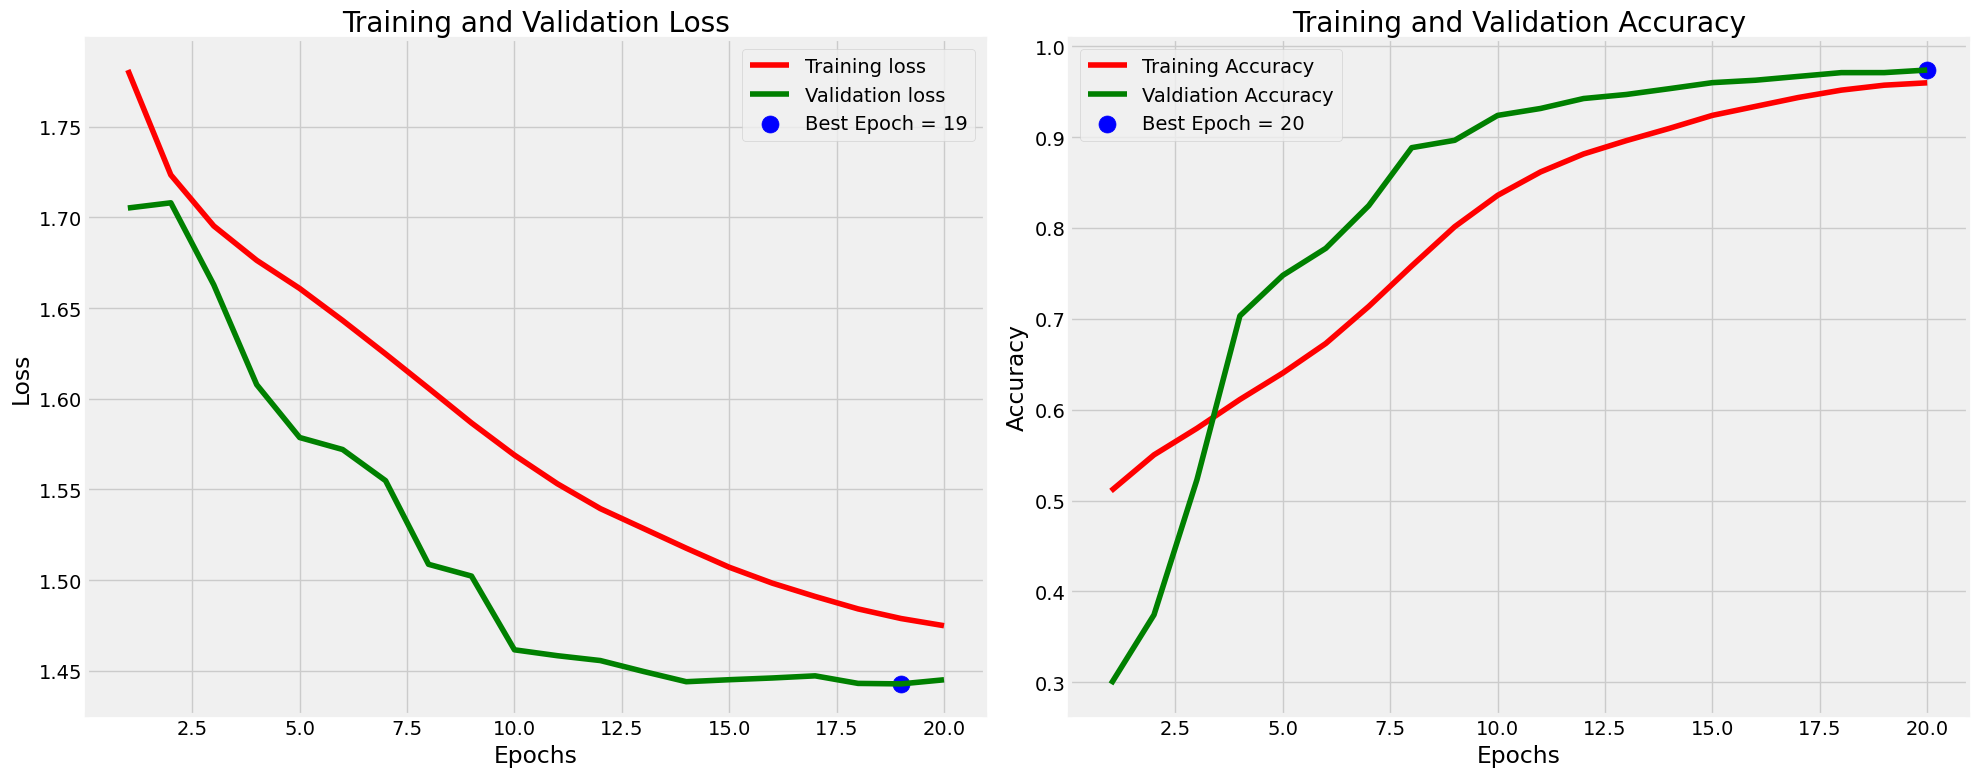

In [15]:
plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs, train_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs, train_acc, 'r', label ='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label ='Valdiation Accuracy')
plt.scatter(index_acc + 1, acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
loss,acc = model.evaluate(x_test,y_test)
print(f"Loss : {loss}")
print(f"Accuracy : {acc}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.9737 - loss: 1.4502
Loss : 1.4449687004089355
Accuracy : 0.9737715125083923


In [17]:
predict_mask = model.predict(x_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step


In [18]:
predict_mask = (predict_mask > 0.7).astype(np.uint8)

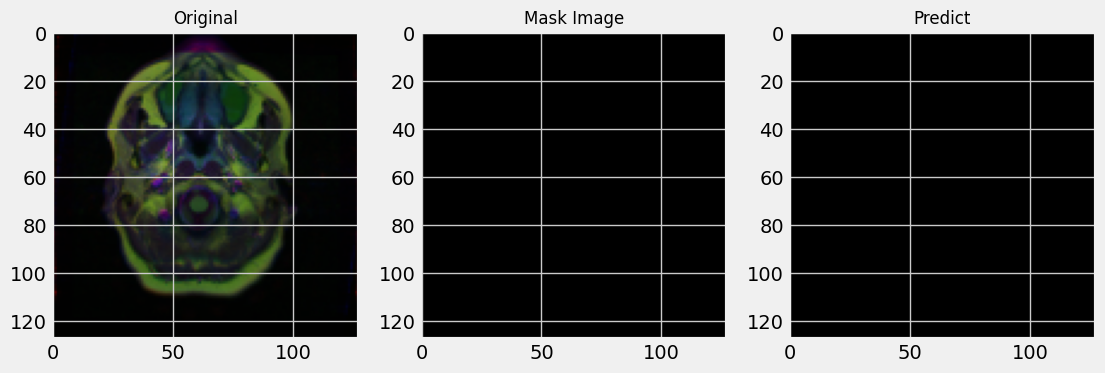

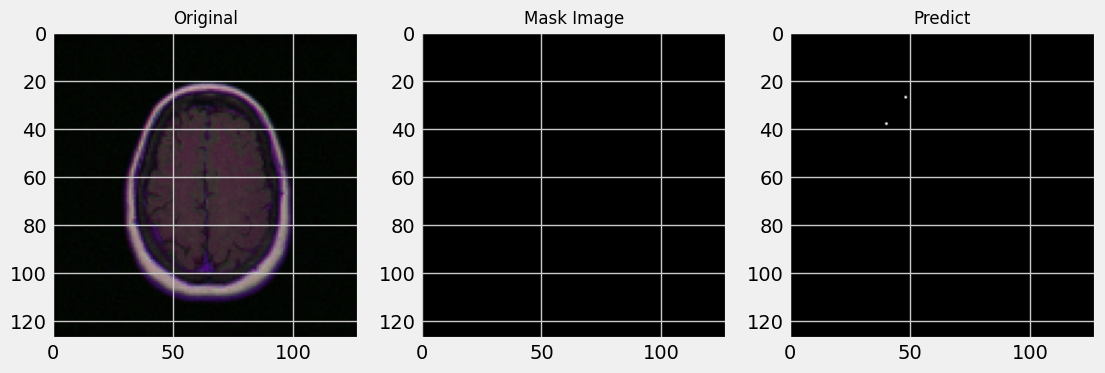

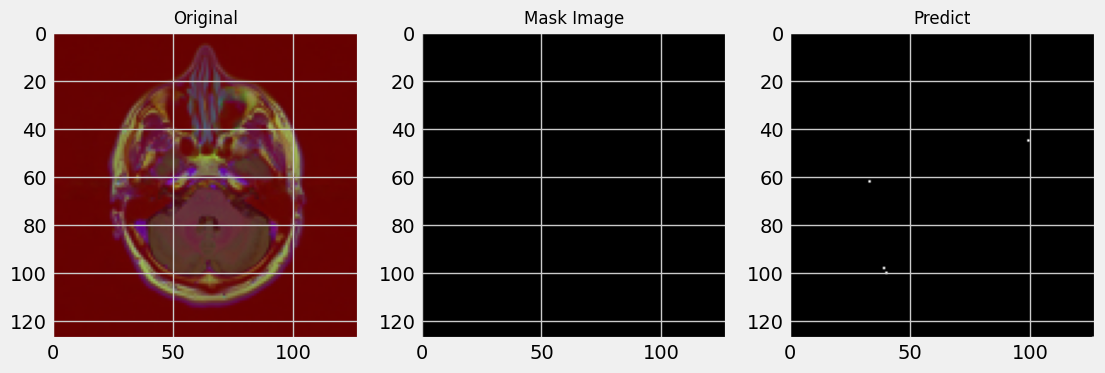

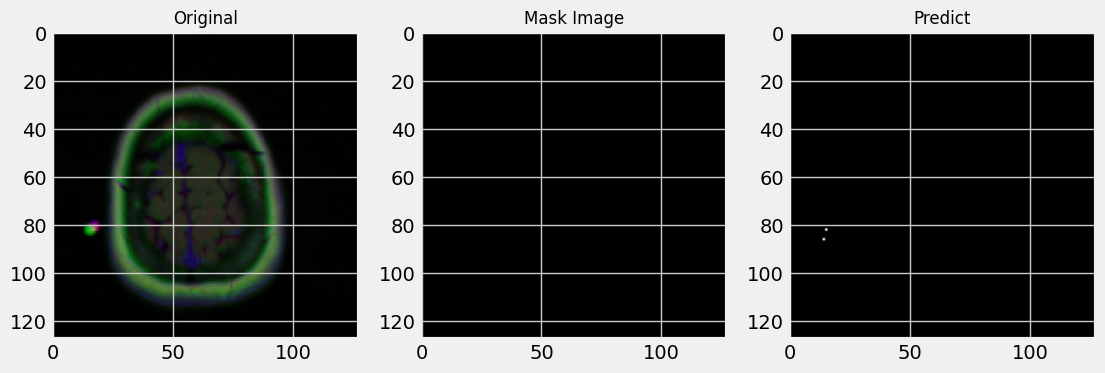

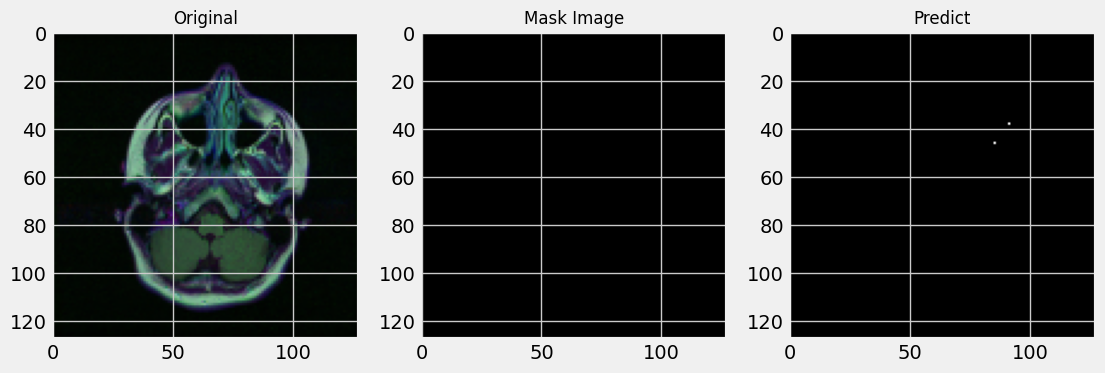

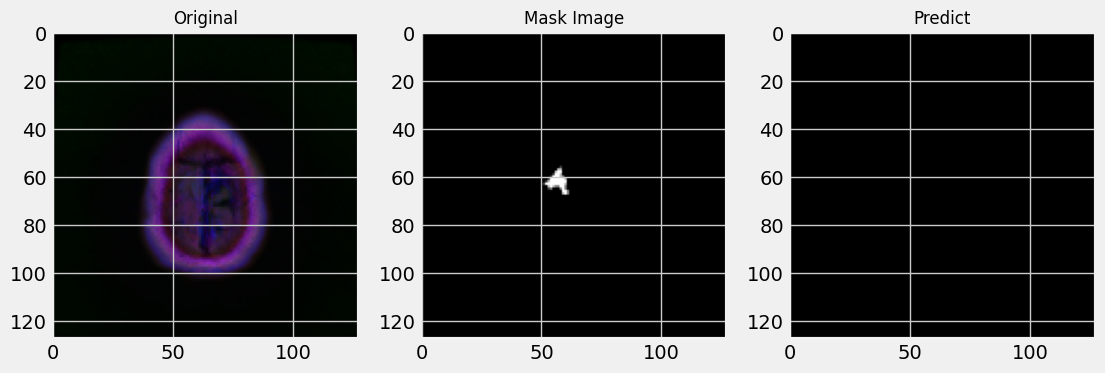

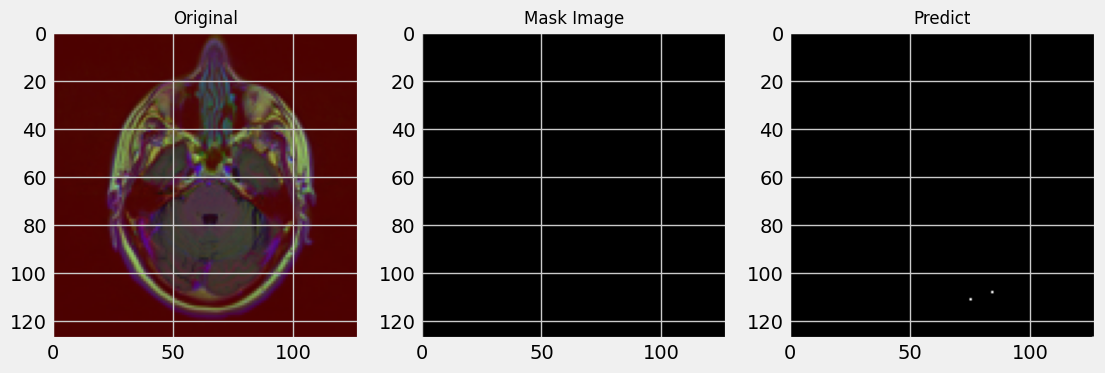

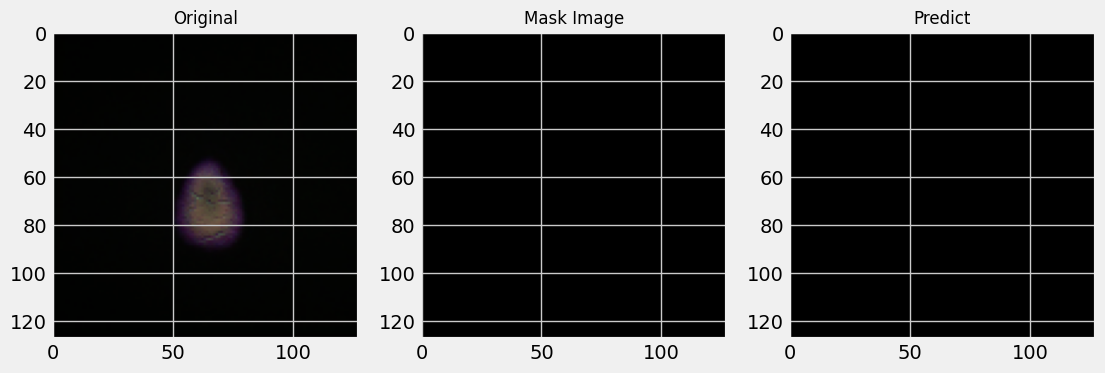

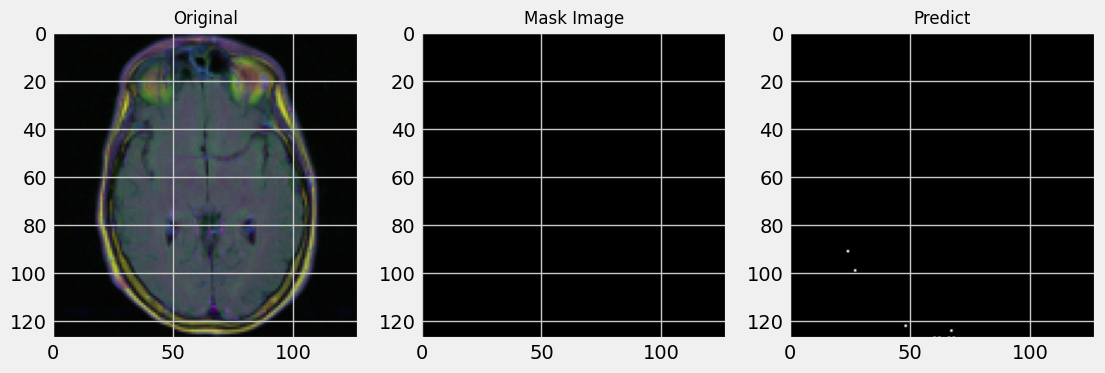

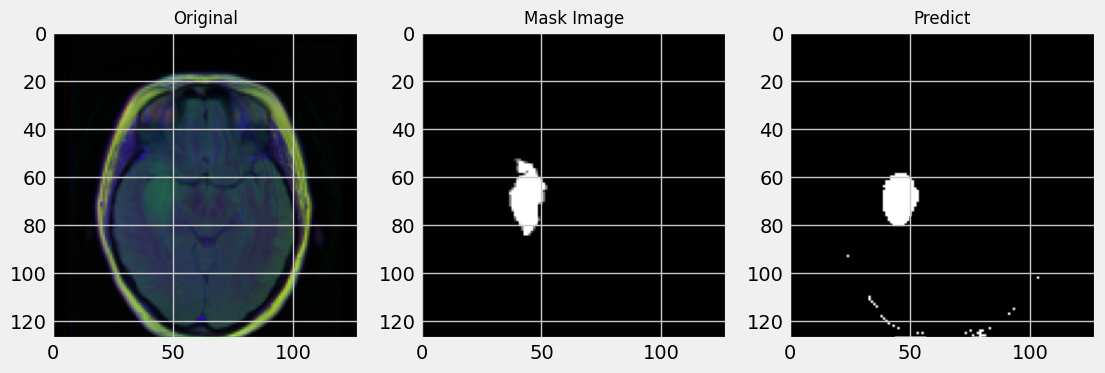

In [19]:
for i in range(0,10):
    plt.figure(figsize = (12,6))

    plt.subplot(1,3,1)
    plt.title('Original', fontsize = 12)
    img = cv.cvtColor(x_test[i], cv.COLOR_BGR2RGB)
    plt.imshow(img)
    
    plt.subplot(1,3,2)
    plt.title('Mask Image', fontsize = 12)
    plt.imshow(y_test[i].squeeze(), cmap = 'gray')
    
    plt.subplot(1,3,3)
    plt.title('Predict', fontsize = 12)
    plt.imshow(predict_mask[i].squeeze(), cmap = 'gray')

    plt.show()

# Model Save

In [20]:
model.save("brain_tumor_segementation.keras")

In [21]:
from IPython.display import FileLink
FileLink("brain_tumor_segementation.keras")

/kaggle/working/brain_tumor_segementation.keras